In [57]:
# Import external tools:
import time 
import random
from matplotlib import pyplot as plt
import librosa
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import torchaudio
import soundfile as sf
from scipy import signal
import getpass
import pandas as pd
import numpy as np
import sys
import os
import importlib
import scipy
from scipy.io import wavfile
from IPython.display import Audio
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# I am running this script on two different computers, so i need to change paths
# depending on computer in use: 
if getpass.getuser()=="joanna.luberadzka":
    projectdir="/Users/joanna.luberadzka/Documents/VAE-IR/"
    datadir="/Users/joanna.luberadzka/Documents/Data/IR_Arni_upload_numClosed_0-5/"
elif getpass.getuser()=="ubuntu":
    projectdir="/home/ubuntu/joanna/VAE-IR/"
    datadir="/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5/"

# Add path of this project
sys.path.insert(0, projectdir+'src/')

# Import and automatically reload my own modules:
import models; importlib.reload(models)
import train; importlib.reload(train)
import datasetprep as dsprep; importlib.reload(dsprep)
import helpers; importlib.reload(helpers)

<module 'helpers' from '/Users/joanna.luberadzka/Projects/VAE-IR/src/helpers.py'>

In [67]:
# I am running this script on two different computers, so i need to change paths
# depending on computer in use: 
if getpass.getuser()=="joanna.luberadzka":
    projectdir="/Users/joanna.luberadzka/Projects/VAE-IR/"
    datadir="/Users/joanna.luberadzka/Data/IR_Arni_upload_numClosed_0-5/"
elif getpass.getuser()=="ubuntu":
    projectdir="/home/ubuntu/joanna/VAE-IR/"
    datadir="/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5/"

# Add path of this project
sys.path.insert(0, projectdir+'src/')

# Import and automatically reload my own modules:
import models; importlib.reload(models)
import train; importlib.reload(train)
import datasetprep as dsprep; importlib.reload(dsprep)
import helpers; importlib.reload(helpers)

<module 'helpers' from '/Users/joanna.luberadzka/Projects/VAE-IR/src/helpers.py'>

In [68]:
# load data:
if getpass.getuser()=="joanna.luberadzka":
    INFO_FILE = projectdir + "irstats_ARNIandBUT_local.csv"
elif getpass.getuser()=="ubuntu":
    INFO_FILE = projectdir+"irstats_ARNIandBUT_datura.csv"

SAMPLING_RATE=8e3
# instantiate data set 
dataset = dsprep.DatasetRirs(INFO_FILE,SAMPLING_RATE,preproc="wave")


In [69]:

# load trained model and plot example:

# ----------- Option 1 : Waveform-to-waveform variational autoencoder with linear layers only ------------
model=models.VAE_Lin(x_len=24000).to("cpu")
model.load_state_dict(torch.load(projectdir + "models/trained_model_WAVEA_01-02-2023--12-17.pth",map_location="cpu"))
# put the model in evaluation mode
model.eval()


# ----------- Option 2 : Waveform-to-waveform variational autoencoder with 1d-convolutional layers ------------
# model=models.Conv1D_VAE(x_len=24000,h_len=256,z_len=24).to("cpu")
# model.load_state_dict(torch.load(projectdir + "models/trained_model_WAVEB_08-02-2023--00-56.pth",map_location="cpu"))
# # put the model in evaluation mode
# model.eval()




VAE_Lin(
  (x2h): Sequential(
    (0): Linear(in_features=24000, out_features=12000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12000, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=256, bias=True)
  )
  (h2mu): Linear(in_features=256, out_features=24, bias=True)
  (h2sigma): Linear(in_features=256, out_features=24, bias=True)
  (z2x): Sequential(
    (0): Linear(in_features=24, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=12000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12000, out_features=24000, bias=True)
  )
)

In [70]:

# Encoding: Using a trained variational autoencoder model, 
# generate a lower-dimensional embedding for each impulse response.

embeddings_mu=[] # list for storing ir embeddings
embeddings_rt=[] # list for storing rt values
embeddings_drr=[] # list for storing drr values
embeddings_isarni=[] # list for storing bool indicating which database
embeddings_edt=[] # list for storing edt vallues
embeddings_cte=[] # list for storing cte values

# take 100 random irs from the data set
ir_rand_indices=random.sample(range(len(dataset)),1000)

for i in ir_rand_indices:
    # get info of an impulse response with a specific index
    ir, labels= dataset[i]
    # encode the input into mu and sigma (standard in VAE)
    mu, sigma = model.encode(ir)
    # mu is the embedding (sigma provides additional info about the uncertainty of this embedding)   
    emb = mu.squeeze(dim=0) 
    # convert to numpy array and append the list of embeddings
    embeddings_mu.append(emb.detach().cpu().numpy())
    embeddings_rt.append(labels["rt"])
    embeddings_drr.append(labels["drr"])
    embeddings_edt.append(labels["edt"])
    embeddings_cte.append(labels["cte"])
    embeddings_isarni.append(labels["isarni"])

# covert from list of arrays to one array
embeddings_mu=np.array(embeddings_mu)
embeddings_mu=np.squeeze(embeddings_mu)


/Users/joanna.luberadzka/venvs/ha_enhancement_experiment/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Text(0.5, 1.0, 'color: isarni')

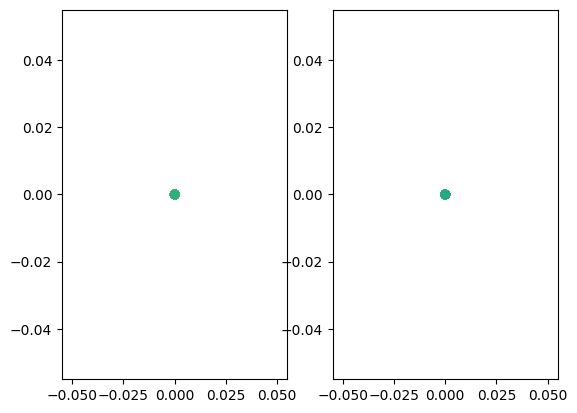

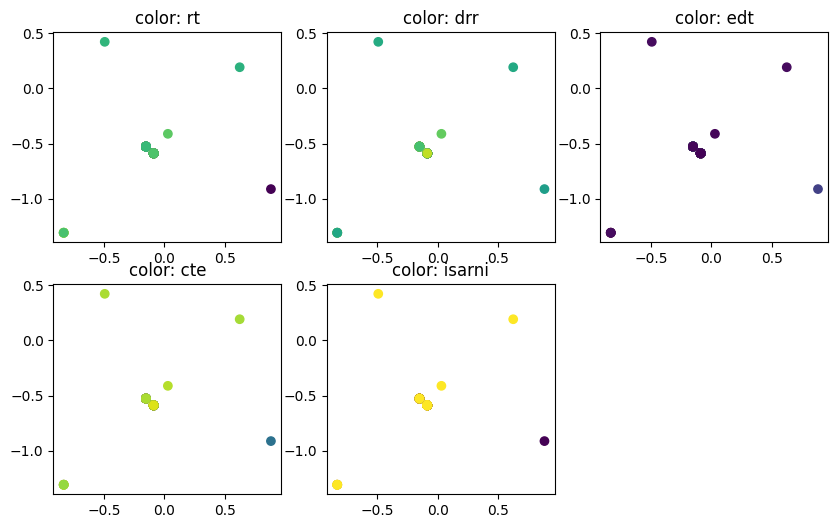

In [71]:

# Visualization: To visualize each encoding, the D-dimensional embeddings 
# have to be reduced to 2 dimensions. This can be done with two methods: 
# PCA (linear) or TSNE (non-linear)
embeddings_pca=PCA(n_components=2).fit_transform(embeddings_mu)
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embeddings_mu)

plt.figure()
plt.subplot(1,2,1)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1],c=embeddings_rt)
plt.subplot(1,2,2)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1],c=embeddings_drr)

plt.figure(figsize=(10,6))
plt.subplot (2,3,1)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=embeddings_rt)
plt.title('color: rt')
plt.subplot (2,3,2)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=embeddings_drr)
plt.title('color: drr')
plt.subplot (2,3,3)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=embeddings_edt)
plt.title('color: edt')
plt.subplot (2,3,4)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=embeddings_cte)
plt.title('color: cte')
plt.subplot (2,3,5)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=embeddings_isarni)
plt.title('color: isarni')

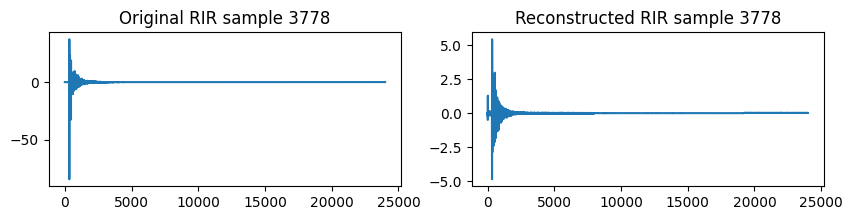

In [64]:
# Reconstruction: Comparing original and reconstructed impulse response (visually)

rand_ir_idx=np.random.randint(len(dataset))
# get info of an impulse response with a random index
ir_orig, labels= dataset[rand_ir_idx]
# encode the input into mu and sigma (standard in VAE)
ir_recon, mu, sigma=model(ir_orig)  

ir_orig_plot=ir_orig.squeeze(1).numpy().T
ir_recons_plot=ir_recon.detach().squeeze(1).numpy().T

plt.figure(figsize=(10,2))
plt.subplot (1,2,1)
plt.plot(ir_orig_plot)
plt.title(f'Original RIR sample {rand_ir_idx}')
plt.subplot (1,2,2)
plt.plot(ir_recons_plot)
plt.title(f'Reconstructed RIR sample {rand_ir_idx}')
plt.show()

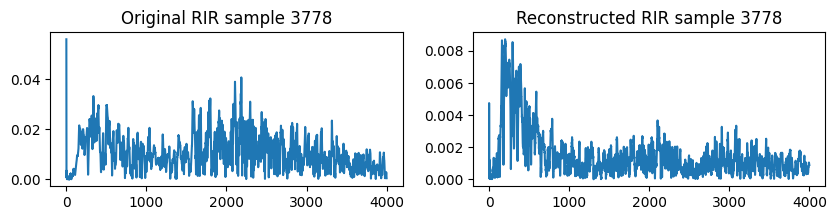

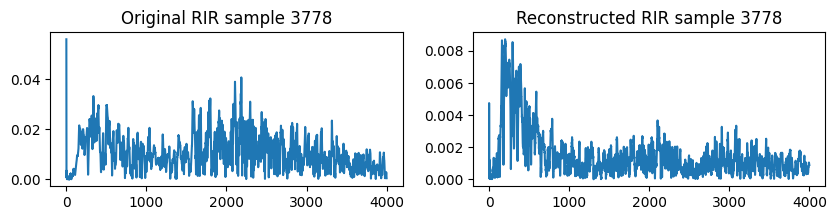

In [65]:
# Reconstruction: Look at the spectrum of the original and reconstructed IRs, filter the additional undesired tones
IR_orig = np.fft.fft2(ir_orig_plot)
IR_recons = np.fft.fft2(ir_recons_plot)

N = ir_orig_plot.shape[0];df = 1.0 / 8e3; freqs_axis = np.linspace(0.0, 1.0/(2.0*df), N//2)

plt.figure(figsize=(10,2))
plt.subplot (1,2,1)
plt.plot(freqs_axis, 2.0/N * np.abs(IR_orig[:N//2]))
plt.title(f'Original RIR sample {rand_ir_idx}')
plt.subplot (1,2,2)
plt.plot(freqs_axis, 2.0/N * np.abs(IR_recons[:N//2]))
plt.title(f'Reconstructed RIR sample {rand_ir_idx}')
plt.show()

IR_recons[np.where(2.0/N*np.abs(IR_recons)> 0.02)]=0

plt.figure(figsize=(10,2))
plt.subplot (1,2,1)
plt.plot(freqs_axis, 2.0/N * np.abs(IR_orig[:N//2]))
plt.title(f'Original RIR sample {rand_ir_idx}')
plt.subplot (1,2,2)
plt.plot(freqs_axis, 2.0/N * np.abs(IR_recons[:N//2]))
plt.title(f'Reconstructed RIR sample {rand_ir_idx}')
plt.show()

ir_recons_plot = np.real(np.fft.ifft2(IR_recons))




In [66]:
# Reconstruction: Compare original and reconstructed ir by listening to the convolved signals

# load anechoic sound file
x, sr_x=torchaudio.load("anechoic.wav")
# resample anechoic signal
x=torchaudio.transforms.Resample(sr_x,8e3)(x)
x=x.T.numpy()
# convolve anechoic signal with RIR: y=x*h
y_ir_recons = signal.fftconvolve(x, ir_recons_plot, mode = 'full')
y_ir_orig = signal.fftconvolve(x, ir_orig_plot, mode = 'full')
# # set signal levels
x=helpers.set_level(x.T,-30)
y_ir_recons=helpers.set_level(y_ir_recons.T,-30)
y_ir_orig=helpers.set_level(y_ir_orig.T,-30)


In [ ]:
Audio(x,rate=8e3)

In [ ]:
Audio(y_ir_orig,rate=8e3)

In [ ]:
Audio(y_ir_recons,rate=8e3)